# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

## Solution 1
First:
- Check for NaN
- Check that dtypes are appropriate for feature.

In [5]:
#your turn
# - first check to see if there are any nulls or inappropriate dtypes
df_offers.info()
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


Looks to be in order. Still possible for NaN's encoded as something else, like customer name 'missing' or 'unknown', so have to keep an eye out for that sort of thing during exercise.

Next:
- Use merge to outer join the DF's on offer_id
- Use pivot_table to create a column for each offer id
- Make column names more interprettable
- Change customer name from index to column
- Check for NaN's
- Inspect results

**Note:** This could have been done just by pivoting transactions table, since the other information from offers is not being kept in the pivot.

In [6]:
#your turn
df = pd.merge(df_offers,df_transactions,on='offer_id',how='outer')
df = pd.pivot_table(df,columns='offer_id',index='customer_name',values='n', fill_value=0)
df.columns = ['offer_' + str(c) for c in df.columns]
df.reset_index(inplace=True)
print("NaN's in df: ",df.isnull().sum().sum())
df.head()

NaN's in df:  0


,customer_name,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

## Solution 2
- What values of $SS$ do you believe represent better clusterings? Why?

This is a rather ambiguous question. In general, lower values represent better clusterings - the lower the value the closer most points are to the centroid of their assigned cluster. There are however **many** exceptions to this. Obviously if $k = n$ then $SS=0$. That is not an ideal value for k though to call each point its own cluster.

Additionally, say the data existed in such a way that half the customers purchased either offer 1 or offer 2, and all other customers made purchases at random. Consider the plot below, pretending it is a 2d representation of the feature space in this hypothetical.

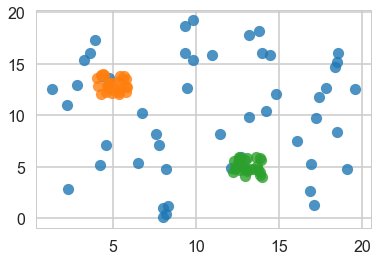

In [7]:
import numpy as np
x = np.random.uniform(0,20,size = 50)
y = np.random.uniform(0,20,size=50)
sns.regplot(x,y, fit_reg=False)
sns.regplot(np.array([5]*25), np.array([13]*25), fit_reg=False, x_jitter = True, y_jitter = True)
sns.regplot(np.array([13]*25), np.array([5]*25), fit_reg=False, x_jitter = True, y_jitter = True)
plt.show()

Here, $k=2$ would result in centroids for the offer 1 and offer 2 purchasing customers and then assign all the others to whichever centroid they happened to closest to. That sort of clustering would give some insight into the structure of the data but result in a lot of customers with meaningless labels. $k=3$ in this example would place two centroids fairly close to where the $k=2$ centroids were, and would place a third centroid wherever the random customers happened to have the most density. This would lower $SS$, but would not really give any better explanation to the clusters, in fact it is arguably worse because the previous 2 centroids would actually move further away from their true centers in order to reduce their distance to the points not contained by the 3rd centroid. The ideal solution to this scenario for interpretation would a cluster for the offer 1 customers, a cluster for the offer 2 customers, and a 3rd cluster for all the erratic customers. But kmeans sadly will never come to this kind of solution because it would not minimize $SS$.

- Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)

In [8]:
x_cols = np.matrix(df.drop('customer_name', axis=1))

- Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.

In [9]:
from sklearn.cluster import KMeans

def get_ss(m, k):
    return KMeans(n_clusters=k).fit(m).inertia_

- Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.

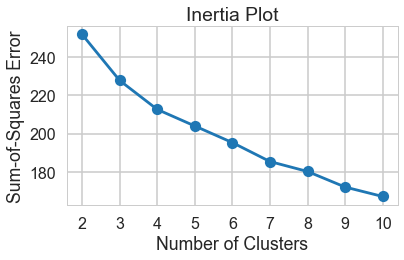

In [10]:
x,y = [],[]
for k in range(2,11):
    x.append(k)
    y.append(get_ss(x_cols,k))
plt.plot(x,y, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-of-Squares Error')
plt.title('Inertia Plot')
plt.tight_layout()
plt.xticks(np.arange(2,11))
plt.show()

There isn't really a 'best' k for this data. I'll say $k=5$ since it flattens out immediately after that.

- Make a bar chart showing the number of points in each cluster for k-means under the best $K$.

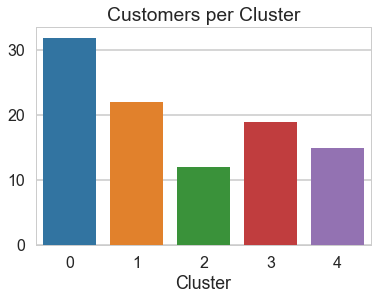

In [11]:
bars = np.unique(KMeans(n_clusters=5).fit(x_cols).labels_, return_counts=True)
sns.barplot(bars[0], bars[1])
plt.xlabel('Cluster')
plt.title('Customers per Cluster')
plt.show()

- What challenges did you experience using the Elbow method to pick $K$?

There wasn't a clear inflection point on the plot, so several values could have been considered. Additionally, the elbow method tells you nothing about how good a fit individual clusters are, only the sum of all error. For instance, at k=4, it could be that 3 of the centroids are near perfect fits for the customers they represent and the 4th is a horrible fit but at the same time k=5 produces 5 clusters that are all fair fits, none great or terrible. Would k=4 be better than k=5? It really depends on what is being categorized, but not having that information available when making the decision is a serious mark against the elbow method.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

## Solution 3

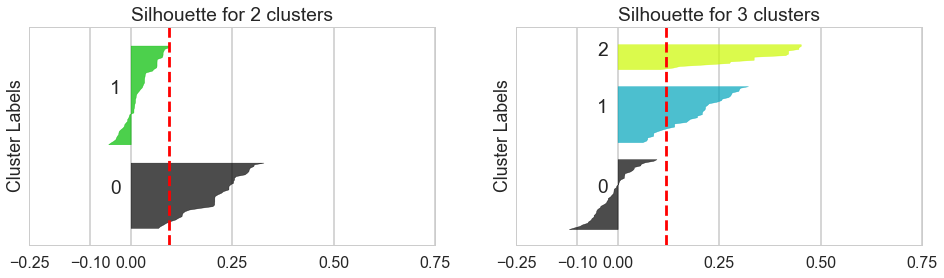

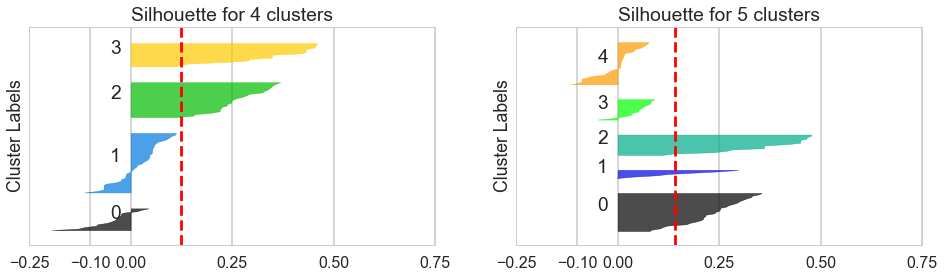

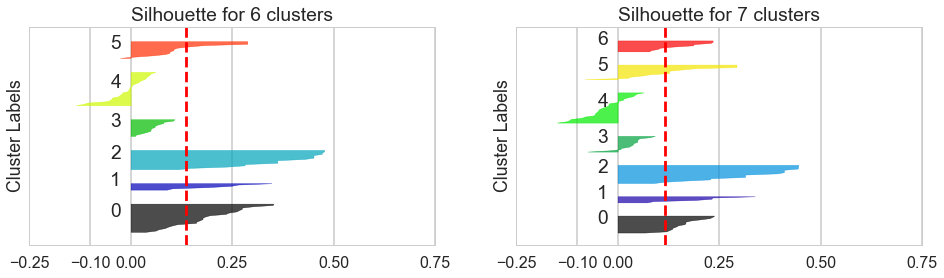

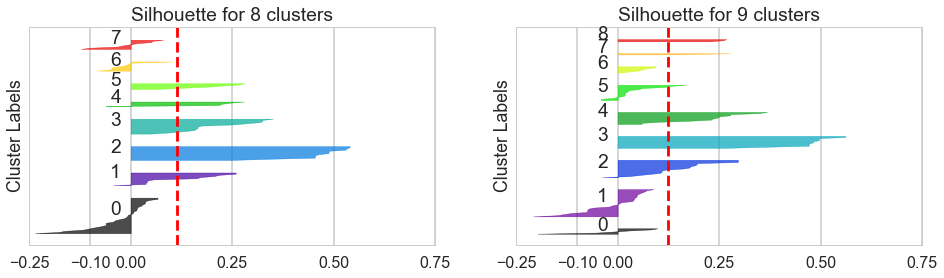

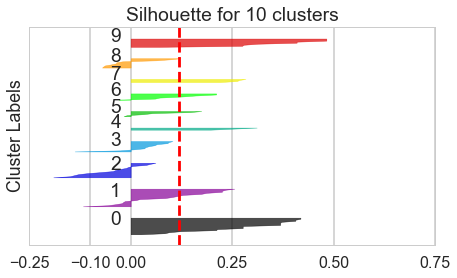

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Your turn.
# NOTE: Recycling most of this code from the referrence article.
sil_score = {}

for n in range(2,11,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    for j in range(1,3):
        k = n + j - 1
        if k != 11:   
            eval('ax'+str(j)).set_xlim([-0.25, .75])
            eval('ax'+str(j)).set_ylim([0, len(x_cols) + (k+1) * 10])
            y_lower = 10
            
            clusters = KMeans(n_clusters=k, random_state=10).fit_predict(x_cols)
            sil_score[k] = silhouette_score(x_cols, clusters)
            sample_silhouette_values = silhouette_samples(x_cols, clusters)

            for i in range(k):
                ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]

                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / k)
                eval('ax'+str(j)).fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
                eval('ax'+str(j)).text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                y_lower = y_upper + 10

            eval('ax'+str(j)).axvline(x=sil_score[k], color="red", linestyle="--")
                    
            eval('ax'+str(j)).set_title("Silhouette for {} clusters".format(k))
            eval('ax'+str(j)).set_xlabel("")
            eval('ax'+str(j)).set_ylabel("Cluster Labels")
            eval('ax'+str(j)).set_yticks([])
            eval('ax'+str(j)).set_xticks([-0.25,-.1, 0, 0.25, 0.5, 0.75])
    if n == 10:
        fig.delaxes(ax2)
    plt.show()

In [13]:
cluster_results = pd.Series(sil_score).to_frame(name='Silhouette_Score')
cluster_results.index.name = 'Clusters'
cluster_results

,Silhouette_Score
Clusters,
2,0.093656
3,0.118899
4,0.123471
5,0.140925
6,0.137180
7,0.116109
8,0.113396
9,0.125060
10,0.119283


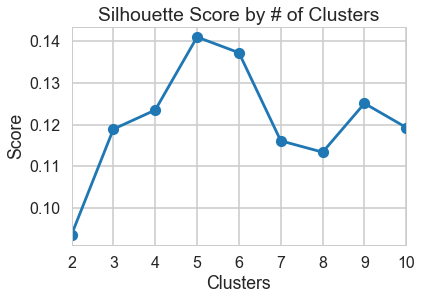

In [14]:
cluster_results.plot(marker='o', legend=False)
plt.title('Silhouette Score by # of Clusters')
plt.ylabel('Score')
plt.xticks(np.arange(2,11))
plt.show()

The plot suggests again that 5 is the optimal number of clusters, but this time with context. The fact that all the scores are well below .25 suggests that this data does not lend itself to such categorization in its present state. Additionally, the silhouette plots allow for examination of how successful the clustering is on a per cluster basis. For instance in k=5, it appears cluster 2 is a decent grouping of points (but this can be deceptive, it might just mean cluster 2 is on the edge of the feature space and as a result the distances of its points to other clusters are very high, resulting in a higher score for its points).

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

## Solution 4

In [20]:
#your turn
from sklearn.decomposition import PCA

pca = pd.DataFrame(PCA(n_components=2).fit_transform(x_cols))
pca.columns = ['x','y']
pca['cluster'] = pd.Series(KMeans(n_clusters=5).fit(x_cols).labels_)
pca['name'] = df.customer_name

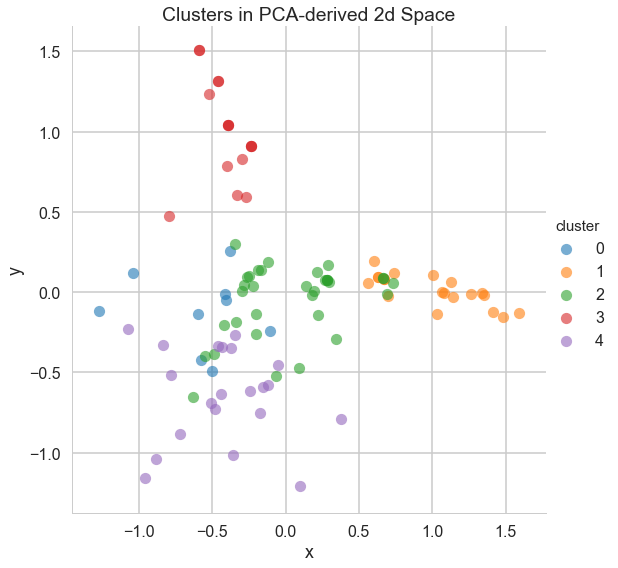

In [26]:
sns.lmplot('x','y', data = pca, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Clusters in PCA-derived 2d Space')
plt.show()

It's still hard to see a clear number of clusters based on this, but maybe 3 would have been a better value for k.

None of the selection methods lead to an optimal result. Inertia plot was closer to identifying 3 than silhouette method.

### Solution 4 - Part 2

Before trying to interpret the meaning of the clusters, I'll first bring in the information from offers, using the transactions table as a bridge. Also, I'll relabel the clusters for a 3 cluster kmeans, since the PCA seemed to suggest that was a more reliable number.

Then I'll look at cluster frequency by time of year, country by cluster, varietal sales per cluster, and discount (binning into 3 quantiles) by cluster, and min quantity.

In [181]:
pca['cluster'] = pd.Series(KMeans(n_clusters=3).fit(x_cols).labels_)
df_transactions['cluster'] =  df_transactions.customer_name.map(pca.set_index('name').cluster)
full_df = df_transactions.merge(df_offers, on="offer_id")

full_df['month'] = pd.to_datetime(full_df.campaign, format='%B').apply(lambda x: x.month)

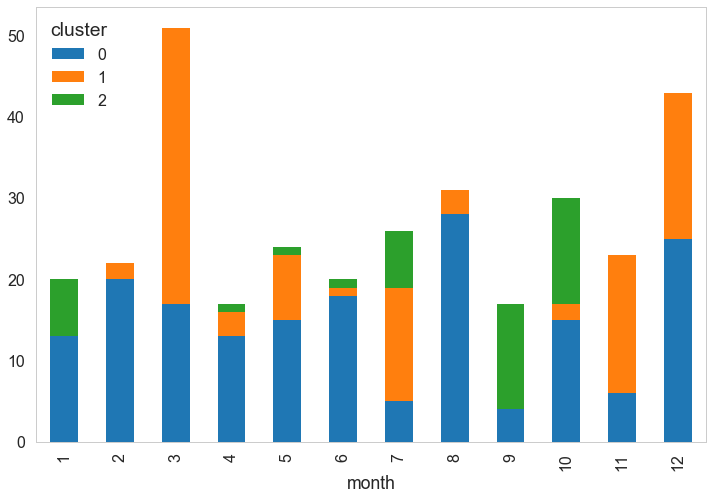

In [182]:
pd.crosstab(full_df.cluster, full_df.month).T.plot(kind='bar',stacked=True,figsize=(12,8), grid = False)

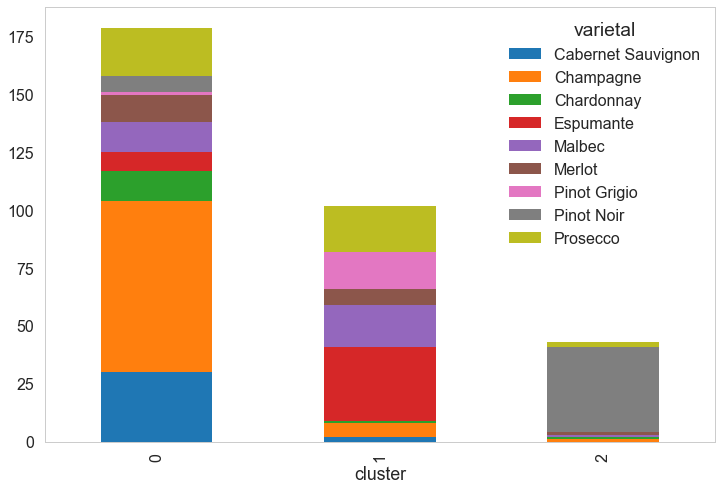

In [183]:
pd.crosstab(full_df.cluster, full_df.varietal).plot(kind='bar',stacked=True,figsize=(12,8), grid = False)

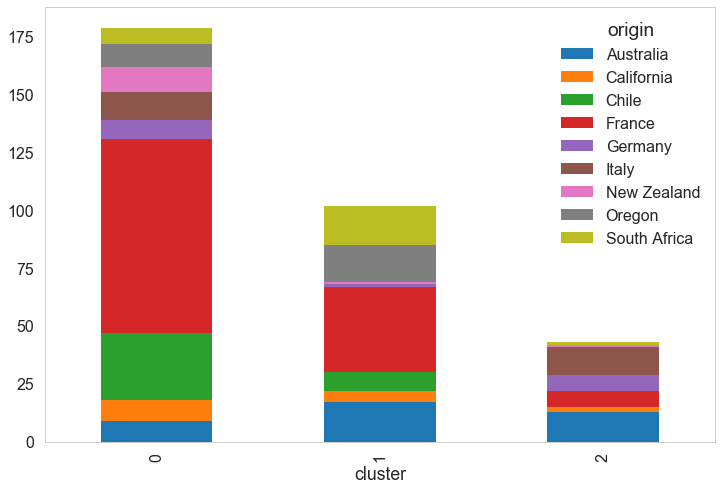

In [184]:
pd.crosstab(full_df.cluster, full_df.origin).plot(kind='bar',stacked=True,figsize=(12,8), grid = False)

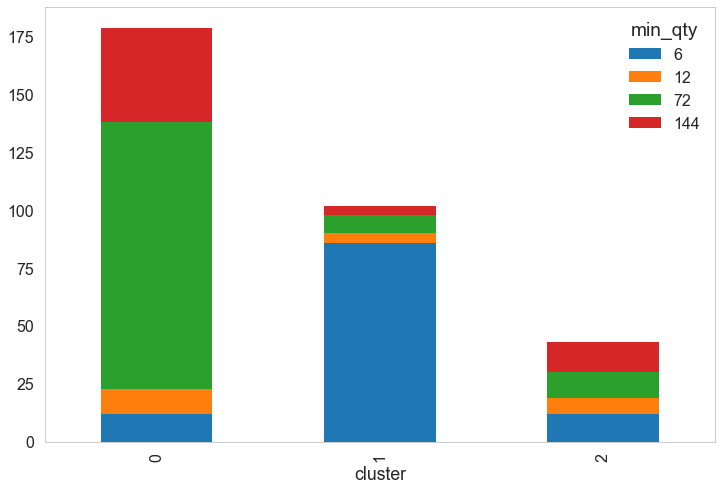

In [185]:
pd.crosstab(full_df.cluster, full_df.min_qty).plot(kind='bar',stacked=True,figsize=(12,8), grid = False)

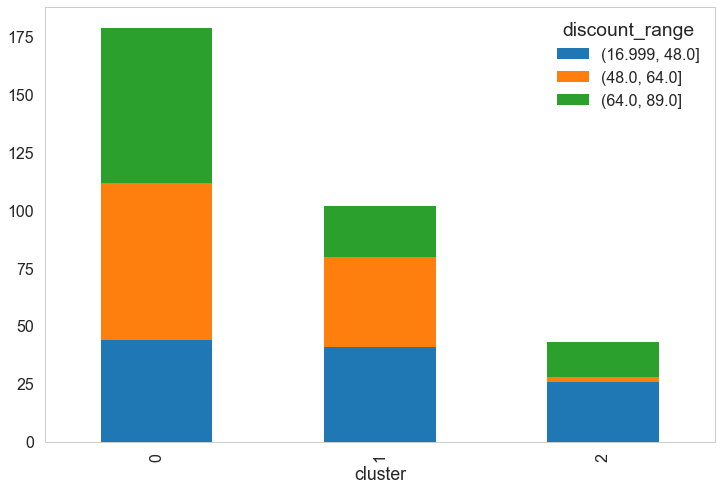

In [196]:
full_df['discount_range'] = pd.qcut(full_df.discount, 3)
pd.crosstab(full_df.cluster, full_df.discount_range).plot(kind='bar',stacked=True,figsize=(12,8), grid = False)

## Key Takeaways
---

That was a lot of visual information at once. Observations by cluster:

#### Cluster 0
- **Seasonality**: Pretty evenly distributed throughout the year. Also nearly all February, April, June, and August sales were offers in this cluster, with a high portion of the October and December sales as well.
- **Varietal**: Customers buy every varietal but primarily made up of Cabernet Sauvignon, Chardonnay, and Champagne. Those three varietals also have nearly no presence in the other clusters.
- **Origin**: Has all origins, but mostly made up of French. Also most of the Chilean and New Zealand wine found in this cluster.
- **Minimum Quantity**: Made up nearly entirely of the two highest quantities. Nearly all of those high minimums are found in this cluster.
- **Discount Range**: Even mix of all 3.

**Conclusion** - This is the bulk order cluster. Customers in this category stock up every other month on Cabernet Sauvignon, Chardonnnay and/or Champagne, especially on French, Chilean and New Zealand wines.

---

#### Cluster 1
- **Seasonality**: Peak sales are in March, July, November and December. 
- **Varietal**: These customers are pretty much the exclusive consumers of Espumante and Pinot Grigio, though they buy other wines, including high levels of Malbec and Prosecco.
- **Origin**: With the exception of German and New Zealand, customers buy wines of all origins with French wines leading the charge.
- **Minimum Quantity**: Customers here not only mainly buy the lowest minimum quantity offers (6), but are pretty much the exclusive buyer of that quantity.
- **Discount Range**: A pretty even mix of all three.

**Conclusion** - Specialty customers partial to Espumante, they tend to reserve most of their purchasing for a few times a year - especially around the holidays.

---

#### Cluster 2
- **Seasonality**: These customers purchase almost exclusively in September and October.
- **Varietal**: These customers only have eyes for Pinot Noir.
- **Origin**: They purchase from a variety of places, but mainly Australia, Germany, and Italy. How these Pinot Noir lovers fail to recognize the quality of the Willamette Wine Valley is beyond the understanding of this totally unbiased Oregonian analyst.
- **Minimum Quantity**: Customers buy pretty evenly from all minimums.
- **Discount Range**: Customers go after the low and high discounts but completely avoid the middle.

**Conclusion** - Lovers of Pinot Noir at high and low prices that do nearly all their spending in early autumn.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

## Solution 5

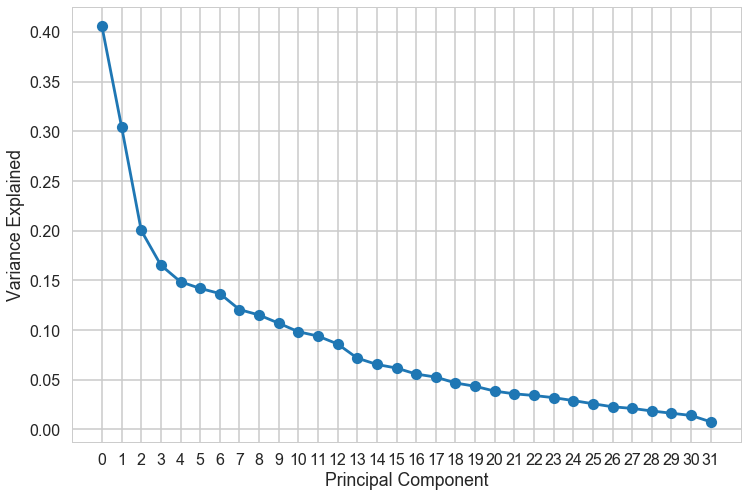

In [206]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
default_pca = sklearn.decomposition.PCA()
default_pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(12,8))
plt.plot(default_pca.explained_variance_, marker = 'o')
plt.ylabel('Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(np.arange(32))
plt.show()

The 5th component (x=4) appears to be the point where the amount of variance explained begins to drop off after. So PCA w/ 5 components would do a pretty solid job of reducing the dimensionality of the data.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


## Solution 6

---

#### Affinity Propogation

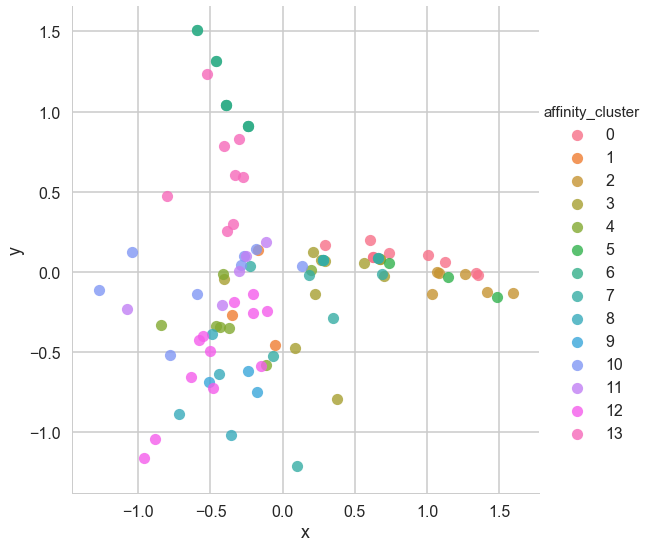

In [211]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, SpectralClustering
# Your turn
pca['affinity_cluster']=AffinityPropagation().fit(x_cols).labels_
sns.lmplot(x='x', y='y', hue='affinity_cluster', data=pca, fit_reg=False, size=8)

#### Spectral Clustering

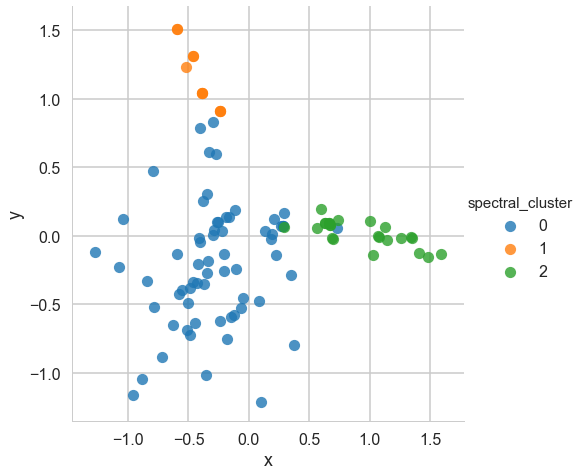

In [217]:
pca['spectral_cluster']=SpectralClustering(n_clusters=3).fit(x_cols).labels_
sns.lmplot(x='x', y='y', hue='spectral_cluster', data=pca, fit_reg=False, size=7)

#### Agglomerative Clustering

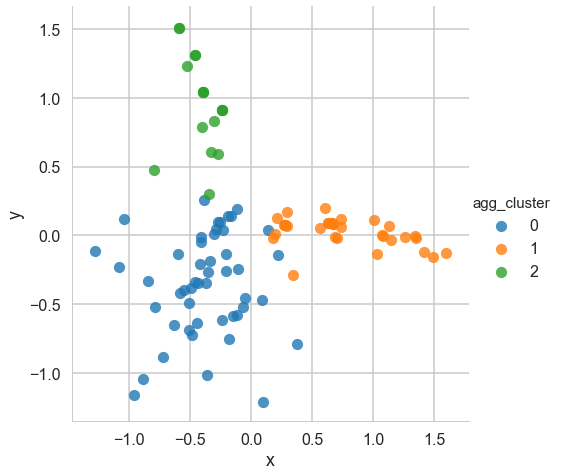

In [222]:
pca['agg_cluster']=AgglomerativeClustering(n_clusters=3).fit(x_cols).labels_
sns.lmplot(x='x', y='y', hue='agg_cluster', data=pca, fit_reg=False, size=7)

#### DBSCAN

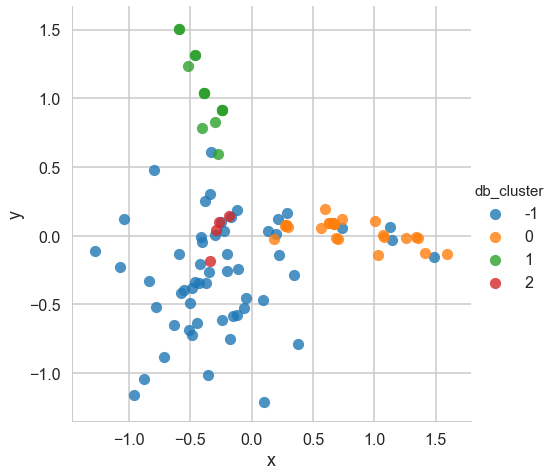

In [234]:
pca['db_cluster']=DBSCAN(min_samples=4, eps = 1.3).fit(x_cols).labels_
sns.lmplot(x='x', y='y', hue='db_cluster', data=pca, fit_reg=False, size=7)

### Conclusions

Agglomerative, DBSCAN and Spectral all perform pretty well from the eye test. Spectral is at an unfair advantage in a test like this, since results are being judged by how the clusters look in reduced dimensions and spectral used dimensionality reduction in determining cluster assignments. DBSCAN gave good results but I had to play with the parameters quite a few times to get them, and still it creates a 4th cluster that doesn't seem to really signify anything.

**Winner** - Agglomerative clustering. Gave the best looking results w/o any tuning. Likely works well on this data because it didn't have strong structure, so by looking at pairwise distances starting with all points in isolation and one-by-one merging together allowed it not to fall victim to the same problems that hindered the distance minimization algorithms.